In [1]:
# Parameters
dataset = "CIFAR10" # CIFAR10, CIFAR100, SVHN
v_type = "mingd" # mingd, rand
root_path = ""
params_path = ""
split_index = 500


In [2]:
# Parameters
dataset = "CIFAR10"
v_type = "mingd"
root_path = "/home/mohammad/transferability/files"
params_path = "/home/mohammad/transferability/src"
split_index = 500


In [3]:
from IPython.display import display, Markdown
v_type2disp = dict(mingd="MinGD", rand="Blind Walk")
display(Markdown(f"# {dataset} - {v_type2disp[v_type]} results"))

# CIFAR10 - MinGD results

In [4]:
import os, sys
sys.path.insert(0, params_path)

import argparse, params, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from importlib import reload
from tqdm.auto import tqdm

import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [5]:
import seaborn as sns
import pandas as pd
import os

In [6]:
from scipy.stats import combine_pvalues, ttest_ind_from_stats, ttest_ind
from functools import reduce
from scipy.stats import hmean

## Use the full vectors to train a linear model

In [7]:
root = os.path.join(root_path,dataset)
model_types = ['zero-shot', 'prune', 'fine-tune', 'extract-label', 'extract-logit', 'distillation', 'teacher']

In [8]:
if v_type == "mingd" and dataset == "CIFAR100": v_type = "topgd"
    
names = ["teacher","distillation","extract-label","extract-logit","zero-shot","fine-tune","pre-act-18","independent"]
trains = {}
tests = {}
for name in names:
    trains[name] = (torch.load(f"{root}/model_{name}_normalized/train_{v_type}_vulnerability.pt"))
    tests[name] = (torch.load(f"{root}/model_{name}_normalized/test_{v_type}_vulnerability.pt"))
mean_cifar = trains["teacher"].mean(dim = (0,1))
std_cifar = trains["teacher"].std(dim = (0,1))

In [9]:
if v_type == "mingd":
    for name in names:
        trains[name] = trains[name].sort(dim = 1)[0]
        tests[name] = tests[name].sort(dim = 1)[0]
        
for name in names:
    trains[name] = (trains[name]- mean_cifar)/std_cifar
    tests[name] = (tests[name]- mean_cifar)/std_cifar
    
f_num = 30
a_num=30

trains_n = {}
tests_n = {}
for name in names:
    trains_n[name] = trains[name].T.reshape(1000,f_num)[:,:a_num]
    tests_n[name] = tests[name].T.reshape(1000,f_num)[:,:a_num]

In [10]:
n_ex = split_index
train = torch.cat((trains_n["teacher"][:n_ex], tests_n["teacher"][:n_ex]), dim = 0)
y = torch.cat((torch.zeros(n_ex), torch.ones(n_ex)), dim = 0)

rand=torch.randperm(y.shape[0])
train = train[rand]
y = y[rand]

In [11]:
model = nn.Sequential(nn.Linear(a_num,100),nn.ReLU(),nn.Linear(100,1),nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.1)

In [12]:
with tqdm(range(1000)) as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        inputs = train
        outputs = model(inputs)
        loss = -1 * ((2*y-1)*(outputs.squeeze(-1))).mean()
        loss.backward()
        optimizer.step()
        pbar.set_description('loss {}'.format(loss.item()))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Dataset Inference

In [13]:
def get_p(outputs_train, outputs_test):
    pred_test = outputs_test[:,0].detach().cpu().numpy()
    pred_train = outputs_train[:,0].detach().cpu().numpy()
    tval, pval = ttest_ind(pred_test, pred_train, alternative="greater", equal_var=False)
    if pval < 0:
        raise Exception(f"p-value={pval}")
    return pval

def get_p_values(num_ex, train, test, k):
    total = train.shape[0]
    sum_p = 0
    p_values = []
    positions_list = []
    for i in range(k):
        positions = torch.randperm(total)[:num_ex]
        p_val = get_p(train[positions], test[positions])
        positions_list.append(positions)
        p_values.append(p_val)
    return p_values

def get_fischer(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return combine_pvalues(p_values, method="mudholkar_george")[1]

def get_max_p_value(num_ex, train, test, k):
    p_values = get_p_values(num_ex, train, test, k)
    return max(p_values)

In [14]:
outputs_tr = {}
outputs_te = {}
for name in names:
    outputs_tr[name] = model(trains_n[name])
    outputs_te[name] = model(tests_n[name])

In [15]:
import scipy.stats as stats
def print_inference(outputs_train, outputs_test):
    m1, m2 = outputs_test[:,0].mean(), outputs_train[:,0].mean()
    pval = get_p(outputs_train, outputs_test)
    print(f"p-value = {pval} \t| Mean difference = {m1-m2}")

In [16]:
for name in names:
    outputs_tr[name], outputs_te[name] = outputs_tr[name][split_index:], outputs_te[name][split_index:]

In [17]:
for name in names:
    print(f"{name}")
    print_inference(outputs_tr[name], outputs_te[name])

teacher
p-value = 9.471827244290652e-67 	| Mean difference = 0.8518033027648926
distillation
p-value = 7.00831746709577e-35 	| Mean difference = 0.5558339357376099
extract-label
p-value = 1.1670189413330969e-30 	| Mean difference = 0.469926118850708
extract-logit
p-value = 1.3932107627373622e-43 	| Mean difference = 0.5647839307785034
zero-shot
p-value = 9.505112444868077e-22 	| Mean difference = 0.42093271017074585
fine-tune
p-value = 1.9153199821774074e-65 	| Mean difference = 0.8286807537078857
pre-act-18
p-value = 1.5391024251650987e-42 	| Mean difference = 0.6405919790267944
independent
p-value = 0.14952548002422886 	| Mean difference = 0.061785608530044556


## Main Loop

In [18]:
if not os.path.exists(f"{dataset}_{v_type}.h5"):
    total_reps = 40
    max_m = 45
    total_inner_rep = 100

    m_list = [x for x in range(2, max_m, 1)]
    p_values_all_threat_models_dict = {}

    n_pbar = tqdm(names, leave=False)
    for name in n_pbar:
        p_vals_per_rep_no = {}
        r_pbar = tqdm(range(total_reps), leave=False)
        for rep_no in r_pbar:
            p_values_list = []
            for m in m_list:
                p_list = get_p_values(m, outputs_tr[name], outputs_te[name], total_inner_rep)
                try:
                    hm = hmean(p_list)
                except:
                    hm = 1.0
                p_values_list.append(hm)
                pbar.set_description(f"{rep_no: 2d} {name} m={m: 3d}: f{hm: 0.5f}")
            r_pbar.set_description(f"rep_no: {rep_no+1}/{total_reps}")
            p_vals_per_rep_no[rep_no] = p_values_list
        p_values_all_threat_models_dict[name] = p_vals_per_rep_no
        
    df_list = []
    for name, rep_dict in p_values_all_threat_models_dict.items():
        df = pd.DataFrame(rep_dict).reset_index().assign(m=lambda r: r.index+2).drop(["index"], axis=1)
        df_list.append(pd.melt(df,id_vars=["m"], var_name="rep_no", value_name="p_value").assign(threat_model=name))
    results_df = pd.concat(df_list)
    
    results_df.to_hdf(f"{dataset}_{v_type}.h5", v_type)
    results_df
else:
    results_df = pd.read_hdf(f"{dataset}_{v_type}.h5", v_type)

#### Plotting

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.latex.preamble'] = r'\usepackage{times}'

plt.rcParams.update({
    "text.usetex": True,
})

#### Renaming

In [20]:
rename_dict = {
    "threat_model": "Threat Model", 
    "teacher": "Source", 
    "distillation": "Distillation", 
    "extract-label": "Label-Query", 
    "extract-logit": "Logit-Query", 
    "zero-shot": "Zero-Shot Learning",
    "fine-tune": "Fine-Tuning",
    "pre-act-18": "Diff. Architecture",
    }

In [21]:
plot_df = (results_df.rename(columns=rename_dict).replace(rename_dict)
           .query('(m >= 5)')
          )

In [22]:
# Sizes
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 1
BIGGER_SIZE = MEDIUM_SIZE + 1
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsi ze of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, 'p-value')

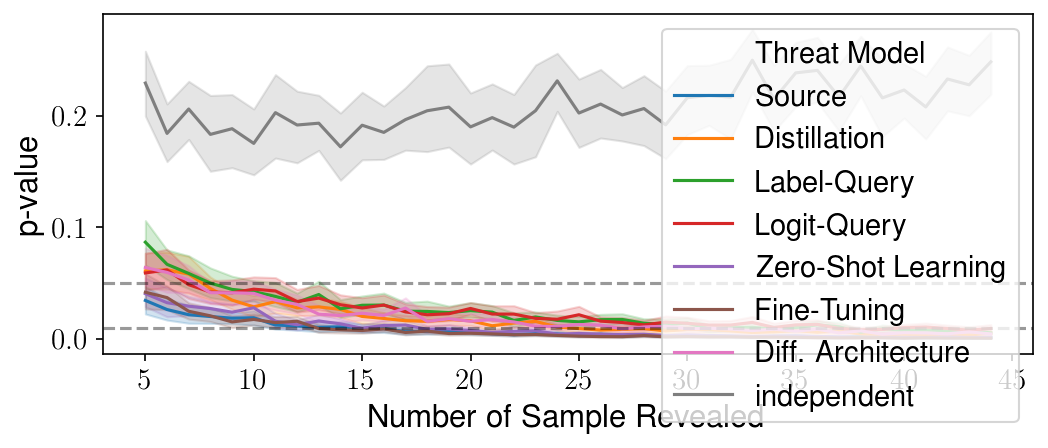

In [23]:
fig, ax = plt.subplots(figsize=(8, 3), dpi=150)
g = sns.lineplot(x="m", y="p_value", hue="Threat Model", data=plot_df, ax=ax, ci=99)
g.axhline(0.05, ls='--', color="black", alpha=0.4)
g.axhline(0.01, ls='--', color="black", alpha=0.4)
g.set_xlabel("Number of Sample Revealed")
g.set_ylabel("p-value")

# Table

In [24]:
from utils import generate_table
tab = generate_table(selected_m=10, outputs_te=outputs_te, outputs_tr=outputs_tr, names=names)

  0%|          | 0/8 [00:00<?, ?it/s]

In [25]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab)

               mean_diff  p_value
teacher            0.838    0.000
distillation       0.586    0.000
pre-act-18         0.645    0.000
zero-shot          0.371    0.024
fine-tune          0.832    0.000
extract-label      0.475    0.001
extract-logit      0.563    0.001
independent        0.103    1.000


In [26]:
with pd.option_context("display.float_format", lambda x: f"{x: 0.3f}"):
    print(tab.to_latex(formatters=dict(mean_diff="{:0.3f}".format, p_value=lambda x: "$10^{"+f"{x:0.0E}"[2:]+"}$"), escape=False))

\begin{tabular}{lrr}
\toprule
{} & mean_diff &    p_value \\
\midrule
teacher       &     0.838 & $10^{-04}$ \\
distillation  &     0.586 & $10^{-04}$ \\
pre-act-18    &     0.645 & $10^{-04}$ \\
zero-shot     &     0.371 & $10^{-02}$ \\
fine-tune     &     0.832 & $10^{-05}$ \\
extract-label &     0.475 & $10^{-03}$ \\
extract-logit &     0.563 & $10^{-03}$ \\
independent   &     0.103 & $10^{+00}$ \\
\bottomrule
\end{tabular}

